In [70]:
import pandas as pd
import numpy as np

orders = pd.read_csv("AdsPower-Global-7.7.18-arm64/olist_orders_dataset.csv")
order_items = pd.read_csv("AdsPower-Global-7.7.18-arm64/olist_order_items_dataset.csv")
payments = pd.read_csv("AdsPower-Global-7.7.18-arm64/olist_order_payments_dataset.csv")
reviews = pd.read_csv("AdsPower-Global-7.7.18-arm64/olist_order_reviews_dataset.csv")
customers = pd.read_csv("AdsPower-Global-7.7.18-arm64/olist_customers_dataset.csv")
sellers = pd.read_csv("AdsPower-Global-7.7.18-arm64/olist_sellers_dataset.csv")
products = pd.read_csv("AdsPower-Global-7.7.18-arm64/olist_products_dataset.csv")
geolocation = pd.read_csv("AdsPower-Global-7.7.18-arm64/olist_geolocation_dataset.csv")


orders = orders[orders["order_status"] == "delivered"].copy()
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")

orders["is_late"] = (
    orders["order_delivered_customer_date"] > orders["order_estimated_delivery_date"]
).astype(int)

order_items_agg = (
    order_items.groupby("order_id")
    .agg(
        n_items=("order_item_id", "count"),
        total_price=("price", "sum"),
        total_freight=("freight_value", "sum"),
        avg_price=("price", "mean"),
    )
    .reset_index()
)

payments_agg = (
    payments.groupby("order_id")
    .agg(
        payment_value=("payment_value", "sum"),
        payment_installments=("payment_installments", "max"),
        main_payment_type=("payment_type", lambda x: x.mode()[0] if len(x) > 0 else np.nan),
    )
    .reset_index()
)

orders = orders.merge(
    customers[["customer_id", "customer_unique_id", "customer_state"]],
    on="customer_id", how="left"
)

seller_info = (
    order_items[["order_id", "seller_id"]]
    .merge(sellers[["seller_id", "seller_state"]], on="seller_id", how="left")
    .groupby("order_id")
    .agg(seller_state=("seller_state", "first"))
    .reset_index()
)
orders = orders.merge(seller_info, on="order_id", how="left")

df = (
    orders.merge(order_items_agg, on="order_id", how="left")
    .merge(payments_agg, on="order_id", how="left")
)

df["purchase_to_estimated_days"] = (
    df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]
).dt.days
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_dow"] = df["order_purchase_timestamp"].dt.dayofweek

customer_order_count = (
    customers.groupby("customer_unique_id")["customer_id"]
    .count()
    .reset_index(name="customer_order_count")
)
df = df.merge(customer_order_count, on="customer_unique_id", how="left")

seller_scores = (
    order_items.merge(reviews[["order_id", "review_score"]], on="order_id", how="left")
    .merge(sellers[["seller_id"]], on="seller_id", how="left")
)
seller_avg = (
    seller_scores.groupby("seller_id")["review_score"].mean().reset_index(name="seller_avg_score")
)

df = df.merge(order_items[["order_id", "seller_id"]].drop_duplicates(), on="order_id", how="left")
df = df.merge(seller_avg, on="seller_id", how="left")

df["same_state"] = (df["customer_state"] == df["seller_state"]).astype(int)

df.reset_index(drop=True, inplace=True)

print("Final dataset shape:", df.shape)
print(df.head())

df.to_csv("olist_prepared_data.csv", index=False)

Final dataset shape: (97819, 26)
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26

Text(0.5, 1.0, 'Target varible distribution')

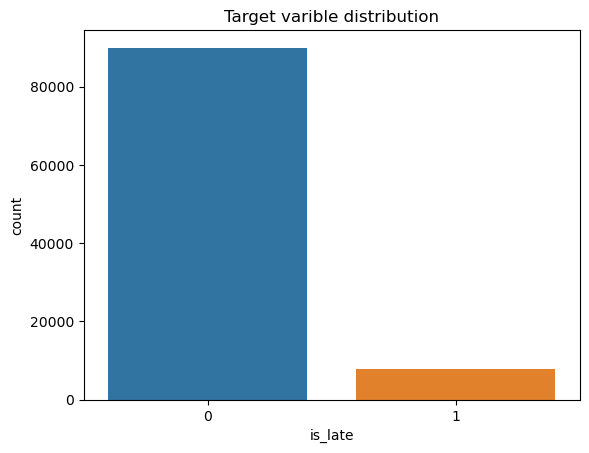

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

target_var=df["is_late"]
feature_matr=df.drop(columns="is_late")

sns.countplot(x="is_late", data=df)
plt.title("Target varible distribution")

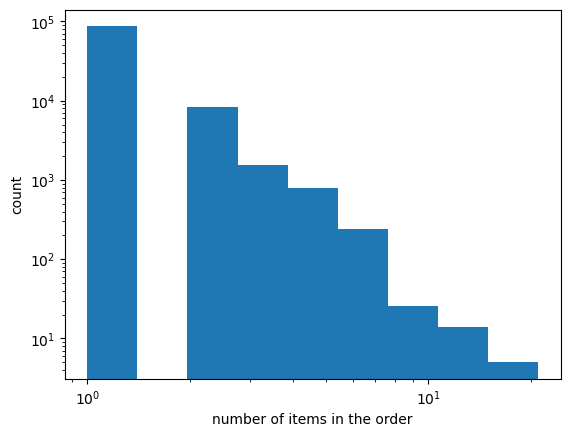

In [72]:
feature_matr["n_items"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["n_items"])),10)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('number of items in the order')
plt.ylabel('count')
plt.show()

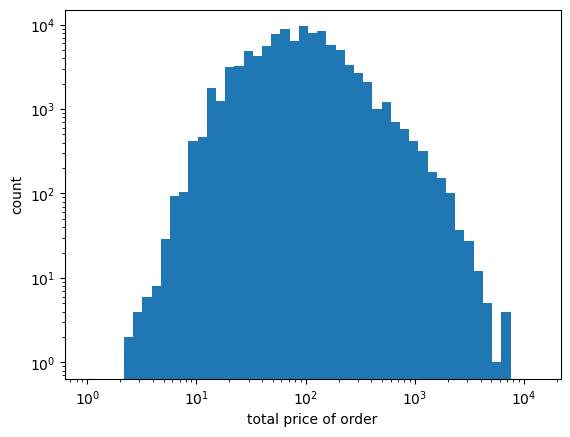

In [73]:
feature_matr["total_price"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["total_price"])),50)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('total price of order')
plt.ylabel('count')
plt.show()

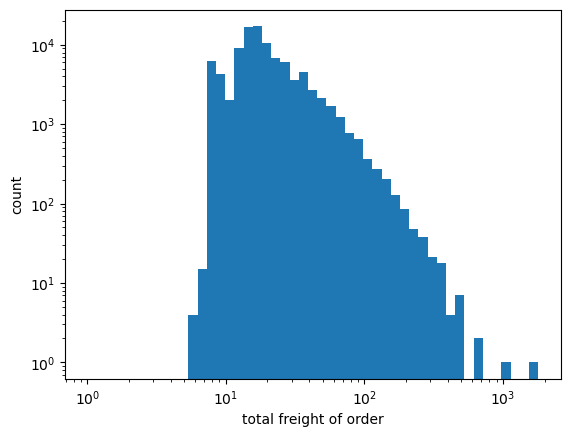

In [74]:
feature_matr["total_freight"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["total_freight"])),50)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('total freight of order')
plt.ylabel('count')
plt.show()

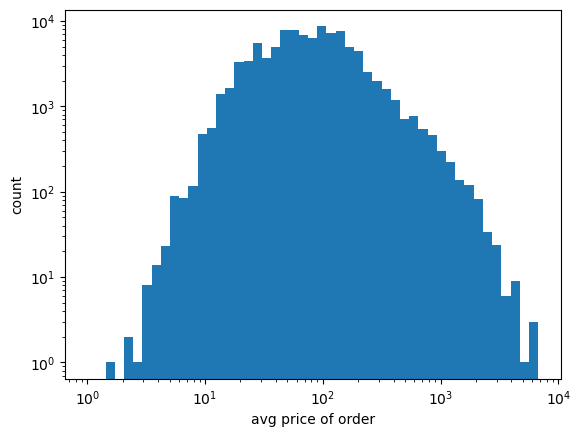

In [75]:
feature_matr["avg_price"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["avg_price"])),50)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('avg price of order')
plt.ylabel('count')
plt.show()

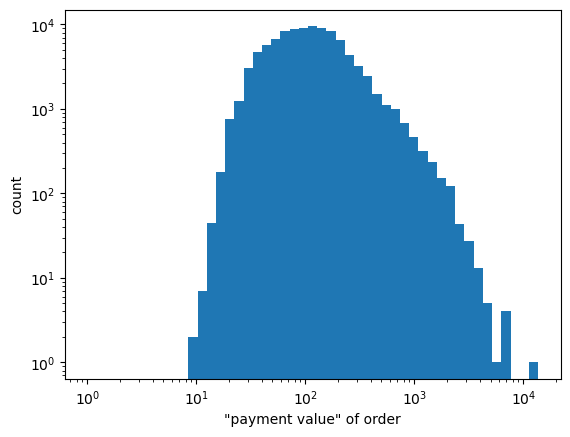

In [76]:
feature_matr["payment_value"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["payment_value"])),50)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('"payment value" of order')
plt.ylabel('count')
plt.show()

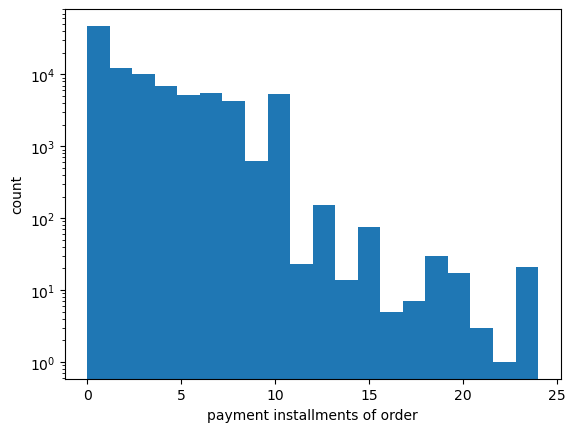

In [77]:
feature_matr["payment_installments"].plot.hist(bins =20) 
plt.semilogy()
plt.xlabel('payment installments of order')
plt.ylabel('count')
plt.show()

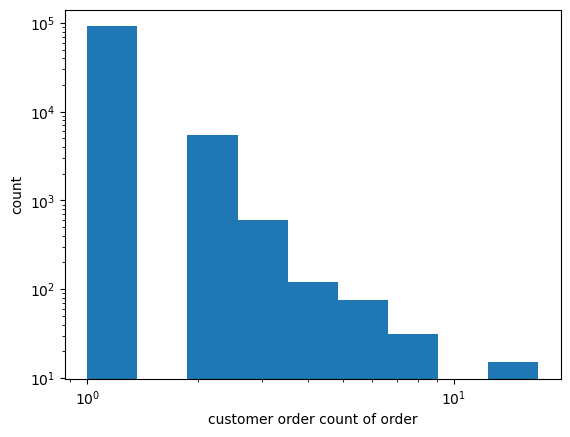

In [78]:
feature_matr["customer_order_count"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["customer_order_count"])),10)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('customer order count of order')
plt.ylabel('count')
plt.show()

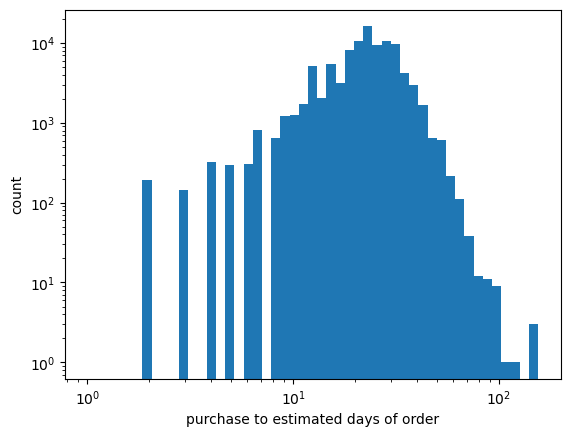

In [79]:
feature_matr["purchase_to_estimated_days"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["purchase_to_estimated_days"])),50)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('purchase to estimated days of order')
plt.ylabel('count')
plt.show()

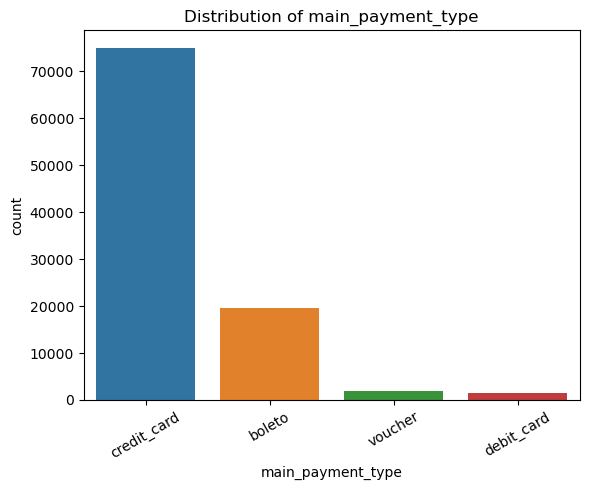

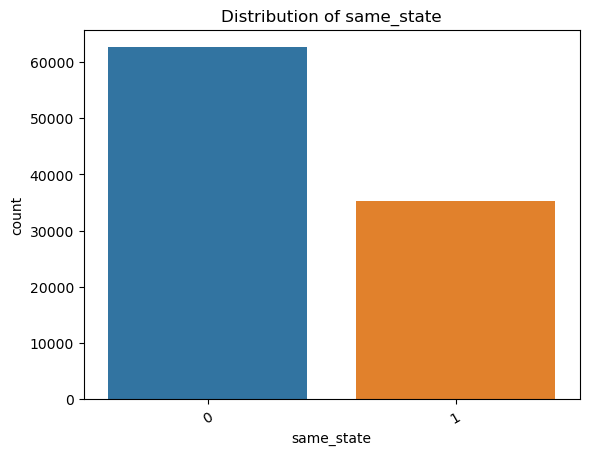

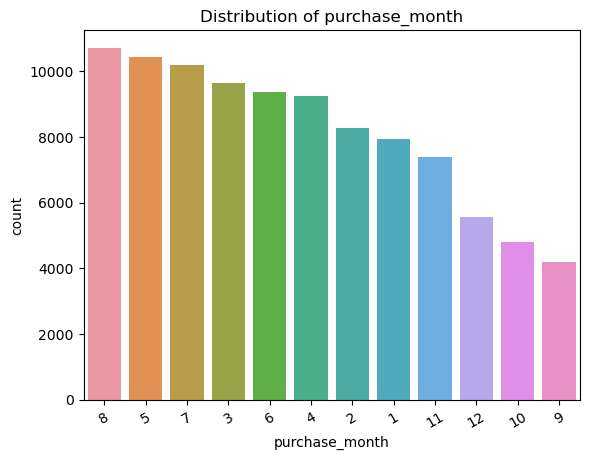

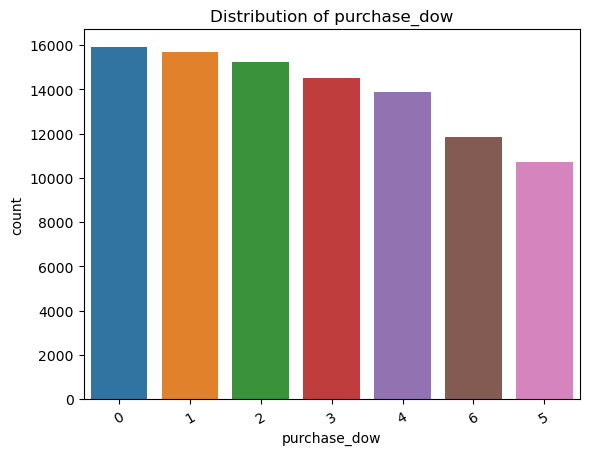

In [110]:
categorical_colsforpic = ["main_payment_type", "same_state", "purchase_month", "purchase_dow"]

for col in categorical_colsforpic:
    plt.figure()
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=30)
    plt.show()

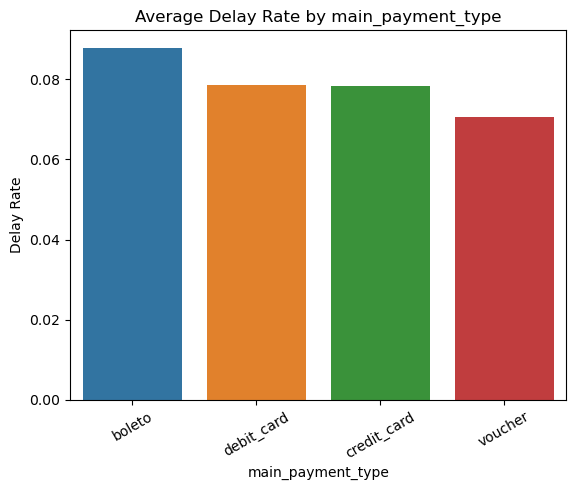

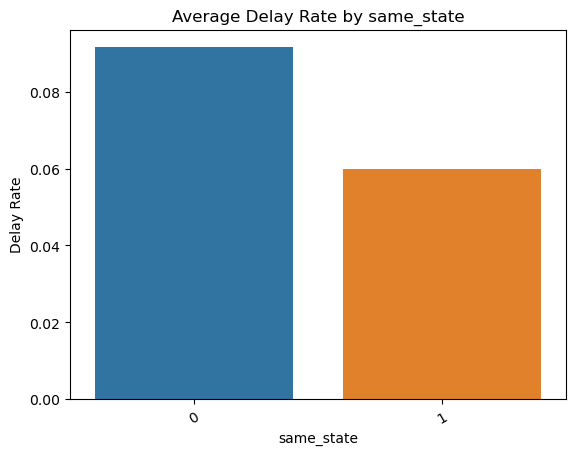

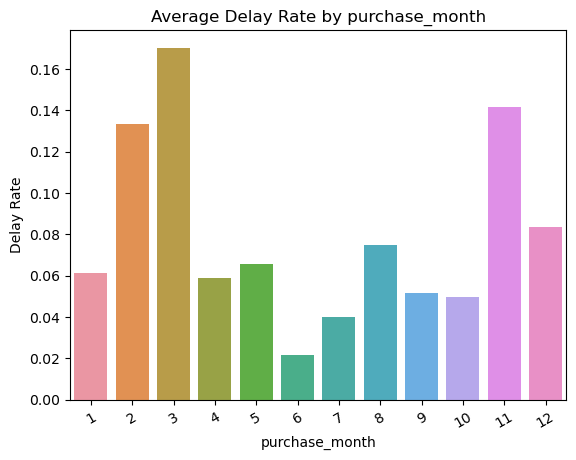

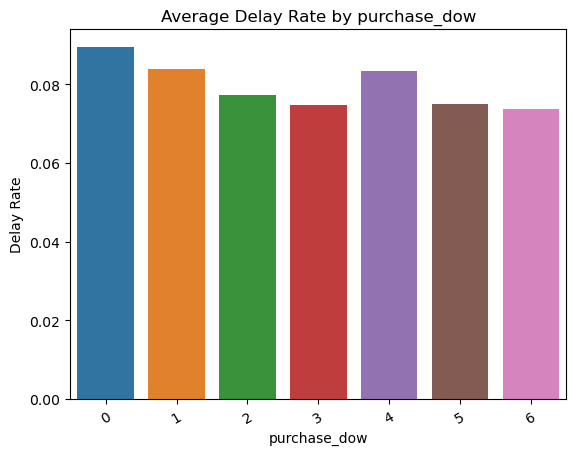

In [88]:
for col in categorical_colsforpic:
    late_by_cat = df.groupby(col)["is_late"].mean().sort_values(ascending=False)
    plt.figure()
    sns.barplot(x=late_by_cat.index, y=late_by_cat.values)
    plt.title(f"Average Delay Rate by {col}")
    plt.ylabel("Delay Rate")
    plt.xticks(rotation=30)
    plt.show()

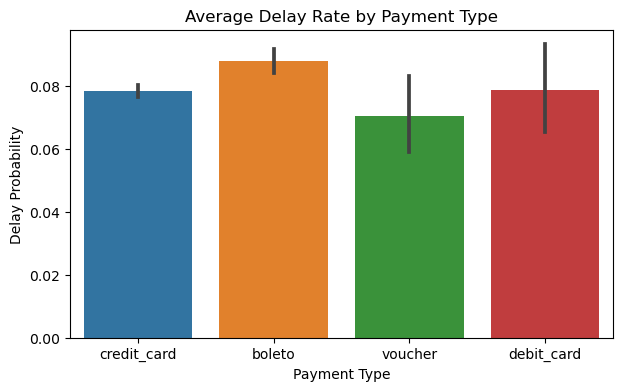

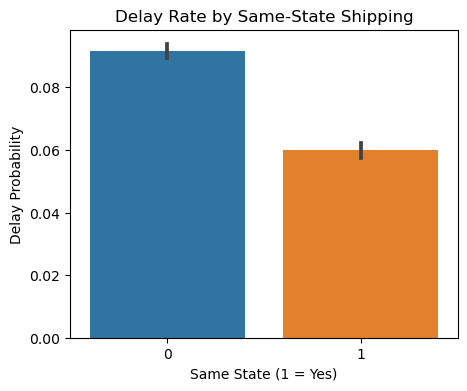

/Users/hct/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/hct/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


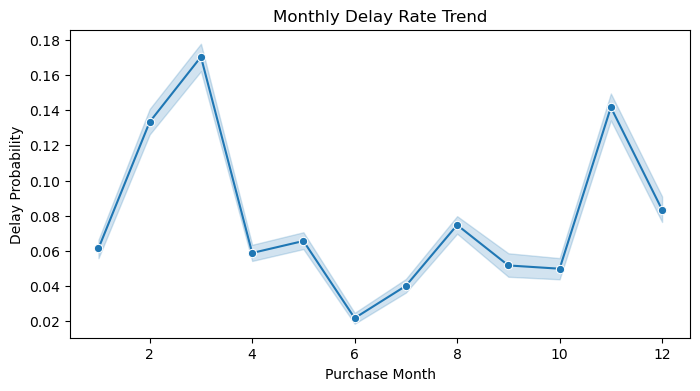

In [83]:
plt.figure(figsize=(7,4))
sns.barplot(x="main_payment_type", y="is_late", data=df, estimator=np.mean, order=df["main_payment_type"].value_counts().index)
plt.title("Average Delay Rate by Payment Type")
plt.ylabel("Delay Probability")
plt.xlabel("Payment Type")
plt.show()

plt.figure(figsize=(5,4))
sns.barplot(x="same_state", y="is_late", data=df, estimator=np.mean)
plt.title("Delay Rate by Same-State Shipping")
plt.ylabel("Delay Probability")
plt.xlabel("Same State (1 = Yes)")
plt.show()

plt.figure(figsize=(8,4))
sns.lineplot(x="purchase_month", y="is_late", data=df, estimator=np.mean, marker="o")
plt.title("Monthly Delay Rate Trend")
plt.ylabel("Delay Probability")
plt.xlabel("Purchase Month")
plt.show()

In [106]:
def missing_value_summary(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0] 
    if missing.empty:
        print("No missing values in this dataset.")
        return None
    missing_df = pd.DataFrame({
        "Missing Count": missing,
        "Missing %": (missing / len(df) * 100).round(9)
    }).sort_values(by="Missing %", ascending=False)
    return missing_df

print("\nMissing Value Summary (Train+Val set):")
display(missing_value_summary(X_other))

print("\n Missing Value Summary (Test set):")
display(missing_value_summary(X_test))


Missing Value Summary (Train+Val set):


,Missing Count,Missing %
seller_avg_score,3,0.003834
payment_value,1,0.001278
payment_installments,1,0.001278
main_payment_type,1,0.001278



 Missing Value Summary (Test set):
No missing values in this dataset.


None

In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

df=df.dropna()
drop_cols = [
    "order_id", "customer_id", "seller_id",
    "order_status",
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

numerical_features = [
    "n_items", "total_price", "total_freight", "avg_price",
    "payment_value", "customer_order_count", "seller_avg_score",
    "purchase_to_estimated_days"
]
ordinal_linear = ["payment_installments"]
ordinal_cyclic = ["purchase_month", "purchase_dow"]
categorical_features = ["main_payment_type", "same_state", "customer_state", "seller_state"]

X = df.drop(columns=["is_late"])
y = df["is_late"]
groups = df["customer_unique_id"]

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=521)
for i_other, i_test in splitter.split(X, y, groups):
    X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
    X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]

X_other = X_other.drop(columns=["customer_unique_id"], errors="ignore")
X_test = X_test.drop(columns=["customer_unique_id"], errors="ignore")

print(f"Train+Val size: {X_other.shape}, Test size: {X_test.shape}")
print(f"Unique customers - Train+Val: {groups_other.nunique()}, Test: {groups_test.nunique()}")
print(f"Overlap check: {len(set(groups_other) & set(groups_test))}")

def encode_cyclic_features(df):
    df = df.copy()
    df["month_sin"] = np.sin(2 * np.pi * df["purchase_month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["purchase_month"] / 12)
    df["dow_sin"] = np.sin(2 * np.pi * df["purchase_dow"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["purchase_dow"] / 7)
    return df.drop(columns=["purchase_month", "purchase_dow"])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features + ordinal_linear),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("cyclic", FunctionTransformer(encode_cyclic_features), ordinal_cyclic)
    ]
)

kf = GroupKFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_other, y_other, groups_other), 1):
    print(f"\nFold {fold}")
    X_train, X_val = X_other.iloc[train_idx], X_other.iloc[val_idx]
    y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]
    preprocessor.fit(X_train)
    X_train_pre = preprocessor.transform(X_train)
    X_val_pre = preprocessor.transform(X_val)
    X_test_pre = preprocessor.transform(X_test)
    
    print(f"Train shape: {X_train_pre.shape}, Val shape: {X_val_pre.shape}, Test shape: {X_test_pre.shape}")

Train+Val size: (78245, 15), Test size: (19570, 15)
Unique customers - Train+Val: 74683, Test: 18671
Overlap check: 0

Fold 1
Train shape: (62596, 68), Val shape: (15649, 68), Test shape: (19570, 68)

Fold 2
Train shape: (62596, 68), Val shape: (15649, 68), Test shape: (19570, 68)

Fold 3
Train shape: (62596, 68), Val shape: (15649, 68), Test shape: (19570, 68)

Fold 4
Train shape: (62596, 68), Val shape: (15649, 68), Test shape: (19570, 68)

Fold 5
Train shape: (62596, 68), Val shape: (15649, 68), Test shape: (19570, 68)
